# Capactiy sum generation from BNETZ-A power plant list
## Example Bavaria
For my bavarian urbs model, I want to extract capacity sums for the (seven) administrative regions of Bavaria (Mittelfranken, Niederbayern, Oberbayern, Oberfranken, Oberpfalz, Schwaben, Unterfranken). Unfortunately, the "Kraftwerkliste" only includes the state, not the region. Luckily, the postal code of the power plant is stated.

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import ExcelWriter

% matplotlib notebook

pd.options.mode.chained_assignment = None  # default='warn'

### Read Kraftwerksliste

In [2]:
file = 'Kraftwerksliste.csv'
powerplants = pd.read_csv(file,sep=';', skiprows=9, index_col=0, decimal=',', thousands='.', na_values='-')

As the column names are not readable, the names will be replaced by short values

In [3]:
col_dict = {'Unternehmen': 'company',
            'Kraftwerksname': 'name',
            'PLZ': 'plz',
            'Ort\n(Standort Kraftwerk)': 'city',
            'Straße und Hausnummer (Standort Kraftwerk)': 'street',
            'Bundesland': 'state',
            'Blockname': 'block',
            'Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit\n(Jahr)': 'start_date',
            'Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale Konservierung\nGesetzlich an Stilllegung gehindert/\nSonderfall)': 'status',
            'Energieträger': 'fuel',
            'Spezifizierung \"Mehrere Energieträger\" und \"Sonstige Energieträger\" - Hauptbrennstoff': 'fuel2',
            'Spezifizierung \"Mehrere Energieträger\" - Zusatz- / Ersatzbrennstoffe': 'fuel3',
            'Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern)': 'fuel_sth',
            'Vergütungsfähig nach EEG\n(ja/nein)': 'is_eeg',
            'Wärmeauskopplung (KWK)\n(ja/nein)': 'is_kwk',
            'Netto-Nennleistung (elektrische Wirkleistung) in MW': 'cap',
            'Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber': 'conn',
            'Netz- oder Umspannebene des Anschlusses in kV': 'voltage',
            'Name Stromnetzbetreiber': 'name_tso' }
powerplants = powerplants.rename(columns=col_dict)

### Bavarian Powerplants
The next steps extract the bavarian power plants and skips the ones without a postal code. Unfortunately, there are 600MW which are not mapped at all. We deal with it later on.

In [4]:
bavarian_pp = powerplants.loc[powerplants.state == 'Bayern']
# filter nan
bpp = bavarian_pp[bavarian_pp.plz.notnull()]
bpp.plz = bpp.plz.astype(np.int32);

<IPython.core.display.Javascript object>


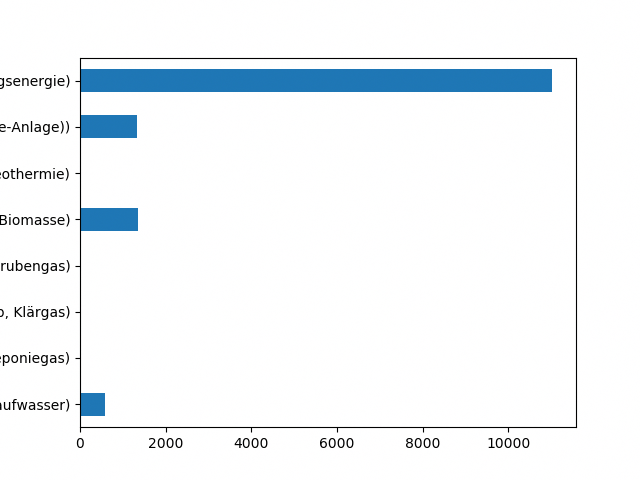

In [5]:
bavarian_pp[bavarian_pp.plz.isnull()][['fuel','cap']].set_index(['fuel']).unstack().plot.barh(stacked=True)

### Excel List which maps PLZ to administrative region
As the postal code in Bavaria is not easily to map within one administrative region (something like range 80000-81000 does not work, as the first two numbers are not necessarily corresponding to just one region), another list is used to map the codes to the respective region.

In [6]:
gd = pd.read_excel(io='Postleitzahlen.xls',sheetname='Onlineprodukt_Gemeinden_300916', index_col=0, parse_cols='D,H,P', skiprows=8705, skip_footer=3837, names=['name', 'plz'])

The next step searches for the first entry in the list with the respective number (each region has a number) and replaces the number with the region name, e.g. 1 with Oberbayern.

In [7]:
rb_dict = {}
for lv in range(1,8):
    rb_dict.update({lv : gd.loc[lv,'name'].iloc[0]})
gd = gd.rename(index=rb_dict)

### Preparation of the Bavarian Power Plant DataFrame
We will add a new column to the DataFrame to insert the new region context

In [8]:
bpp['region'] = np.nan

The region mapping is done in three iterations:
1. The first iteration covers all the "easy" postal codes, which find their corresponding area within the new dataframe.
2. The second iteration helps with the bigger cities, who have many postal codes (like Munich) and searches via the city name.
3. The third and last iteration searches within a range around the postal code, to find the corresponding region.

In [9]:
# Obvious postal codes
for (lvid,lvplz) in bpp.plz.iteritems():
    if lvplz in gd.values:
        region = gd[gd.plz == lvplz].index[0]
        bpp.loc[lvid,'region'] = region

In [10]:
# Naming
for (lvid,lvcity) in bpp.city.loc[bpp.region.isnull()].iteritems():
    if lvcity in gd.values:
        region = gd[gd.name == lvcity].index[0]
        bpp.loc[lvid,'region'] = region

In [11]:
# Postal code range
off = 2 # PLZ offset
for (lvid,lvplz) in bpp.plz.loc[bpp.region.isnull()].iteritems():
    plz_range = set(lv for lv in range(lvplz-off,lvplz+off+1))
    isec = plz_range.intersection(set(gd.plz.values))
    if isec:
        region = gd[gd.plz == list(isec)[0]].index[0]
        bpp.loc[lvid,'region'] = region

In [12]:
# Check values
bpp.loc[bpp.region.isnull()]
# if this dataframe is empty, we are done!

,company,name,plz,city,street,state,block,start_date,status,fuel,fuel2,fuel3,fuel_sth,is_eeg,is_kwk,cap,conn,voltage,name_tso,region
Kraftwerksnummer Bundesnetzagentur,,,,,,,,,,,,,,,,,,,,


### Final aggregation
In the last step, the capacities for the water power plants are summed and stored in a new dataframe!

In [13]:
caps = pd.DataFrame()

for lvfuel in set(bpp.fuel_sth.values) | set (bpp.fuel.values):
    helpdf = bpp.loc[(bpp.fuel == lvfuel) | (bpp.fuel_sth == lvfuel)]
    for lv in np.unique(helpdf.region.values):
        cap_sum = helpdf.loc[helpdf.region == lv].cap.sum()
        caps.loc[lv, lvfuel]= cap_sum
        caps.fillna(0, inplace=True)

In [14]:
caps.sort_index()

,Mineralölprodukte,Biomasse,Kernenergie,Solare Strahlungsenergie,Speicherwasser (ohne Pumpspeicher),Erdgas,Pumpspeicher,Sonstige Energieträger (nicht erneuerbar),Mehrere Energieträger,Laufwasser,Abfall,Windenergie (Onshore-Anlage),Steinkohle
Mittelfranken,0.0,0.0,0.0,0.0,0.0,1019.9,160.0,0.0,840.4,0.0,18.0,94.1,17.4
Niederbayern,19.0,0.0,1410.0,119.9,0.0,136.7,0.0,0.0,0.0,430.9,0.0,0.0,0.0
Oberbayern,910.8,34.9,0.0,0.0,124.0,3092.6,92.0,29.3,1308.6,752.1,87.0,57.7,804.7
Oberfranken,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.8,0.0
Oberpfalz,0.0,15.6,0.0,25.7,0.0,0.0,127.0,0.0,0.0,30.1,54.0,36.5,0.0
Schwaben,57.3,9.6,2572.0,20.0,45.5,75.8,0.0,0.0,18.0,117.6,10.0,0.0,0.0
Unterfranken,0.5,15.9,1275.0,115.4,0.0,353.0,164.0,0.0,96.2,0.0,45.1,152.4,24.8


In [15]:
bpp.loc[((bpp.fuel == 'Erdgas') | (bpp.fuel_sth == 'Erdgas')) & (bpp.block.str.contains('GuD'))]

,company,name,plz,city,street,state,block,start_date,status,fuel,fuel2,fuel3,fuel_sth,is_eeg,is_kwk,cap,conn,voltage,name_tso,region
Kraftwerksnummer Bundesnetzagentur,,,,,,,,,,,,,,,,,,,,
BNA1337e,DS Smith Paper Deutschland GmbH,GuD-Anlage,63741,Aschaffenburg,Weichertstr. 7,Bayern,GuD-Anlage,2013,in Betrieb,Mehrere Energieträger,Erdgas,Biogas,Erdgas,Nein,Ja,47.0,NaN,20,Aschaffenburger Versorgungs GmbH,Unterfranken
BNA0261a,Erlanger Stadtwerke AG,HKW Erlangen,91052,Erlangen,Äußere Bruckerstr. 33,Bayern,GuD I,2005,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Ja,21.6,UW Mitte,20,Erlanger Stadtwerke AG,Mittelfranken
BNA0261c,Erlanger Stadtwerke AG,HKW Erlangen,91052,Erlangen,Äußere Bruckerstr. 33,Bayern,GuD 2,2014,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Ja,6.7,Hammerbacherstr.,20,Erlanger Stadtwerke AG,Mittelfranken
BNA0742,N-ERGIE AG,HKW Sandreuth,90441,Nürnberg,Sandreuthstr. 51,Bayern,GuD 1,2005,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Ja,75.0,U36 Sandreuth,110,N-ERGIE Netz GmbH,Mittelfranken
BNA0743,N-ERGIE AG,HKW Sandreuth,90441,Nürnberg,Sandreuthstr. 51,Bayern,GuD 2,2005,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Ja,75.0,U36 Sandreuth,110,N-ERGIE Netz GmbH,Mittelfranken


In [16]:
bpp.loc[bpp.fuel == 'Pumpspeicher']

,company,name,plz,city,street,state,block,start_date,status,fuel,fuel2,fuel3,fuel_sth,is_eeg,is_kwk,cap,conn,voltage,name_tso,region
Kraftwerksnummer Bundesnetzagentur,,,,,,,,,,,,,,,,,,,,
BNA0337,Donau-Wasserkraft AG,PSW Langenprozelten,97737,Gemünden,NaN,Bayern,entfällt,1974,in Betrieb,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,164.0,loco Kraftwerk,110,DB Energie GmbH,Unterfranken
BNA0422,Uniper Kraftwerke GmbH,Happurg,91230,Happurg,Haupstraße 26,Bayern,Happurg,1958,Sonderfall,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,160.0,Schaltanlage vor Ort,110,Bayernwerk AG,Mittelfranken
BNA0946a,ENGIE Deutschland AG,Kraftwerksgruppe Pfreimd,92555,Trausnitz,Seestraße 6,Bayern,PSKW Tanzmühle,1959,in Betrieb,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,28.0,UW Tanzmühle Schaltfeld E01,110,Bayernwerk AG,Oberpfalz
BNA0953,ENGIE Deutschland AG,Kraftwerksgruppe Pfreimd,92555,Trausnitz,Seestraße 6,Bayern,PSKW Reisach,1955,in Betrieb,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,99.0,UW Reisach Schaltfeld E03-E05,110,Bayernwerk AG,Oberpfalz
BNA0972,Stadtwerke München GmbH,Leitzach 1,83620,Vagen,NaN,Bayern,1,1983,in Betrieb,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,48.0,Schaltstelle Leitzachwerk,110,SWM Infrastruktur GmbH,Oberbayern
BNA0973,Stadtwerke München GmbH,Leitzach 2,83620,Vagen,NaN,Bayern,2,1960,in Betrieb,Pumpspeicher,NaN,NaN,Pumpspeicher,Nein,Nein,44.0,Schaltstelle Leitzachwerk,110,SWM Infrastruktur GmbH,Oberbayern
